In [2]:
from moabb.datasets import AlexMI
import mne
from matplotlib import pyplot as plt
import numpy as np
import biosppy

In [3]:
PATH = "../datasets/"
DOWNLOADED = False

In [4]:
a = AlexMI()

In [4]:
a.download(PATH, update_path=True)

In [5]:
s1 = a.get_data([1])
s1_raw = s1[1]['session_0']['run_0']

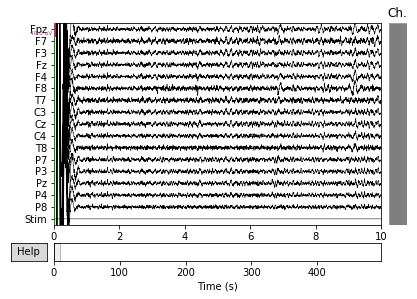

In [7]:
s1_raw.plot()
plt.show()

In [6]:
s1_info = s1_raw.info

In [7]:
s1_chs = s1_info['ch_names']

In [8]:
s1_info['sfreq']

512.0

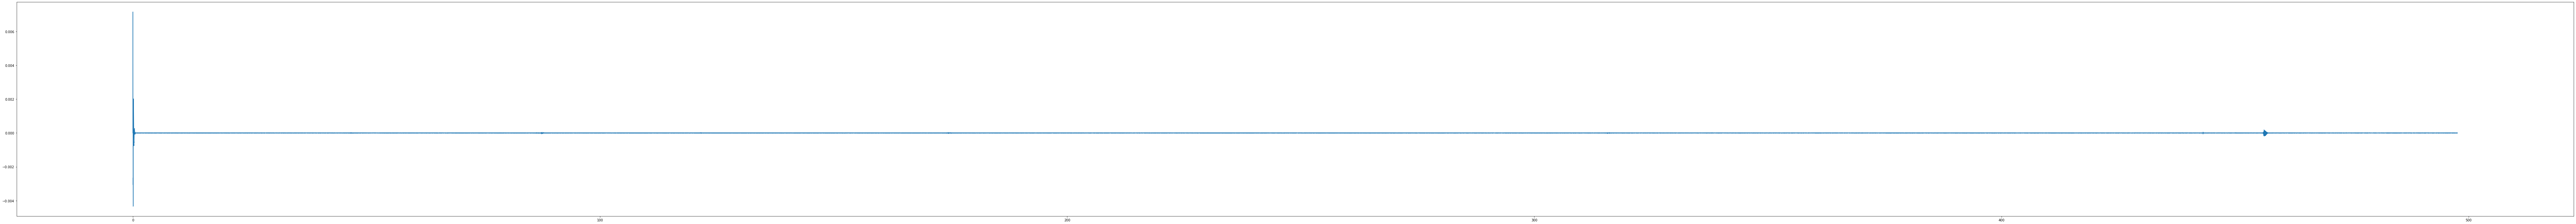

In [11]:
plt.rcParams['figure.figsize'] = [140, 12]
data, t = s1_raw[s1_chs.index('C4')]
plt.plot(t, data.T)

In [17]:
def plot_eeg(t, eeg):
    plt.rcParams['figure.figsize'] = [140, 12]

    fig = plt.figure()
    
    ax_start = 0.1
    ax_step = (0.9 - 0.1) / eeg.shape[0] # Divide graph into channels
    
    axes= []
    colours = ['#A283C4', '#8B2BC4', '#3978E0', '#FFA500', '#3CB2BA', '#FF7685']
    
    for i in range(eeg.shape[0]):
        axes.append(fig.add_axes([0.1, ax_start + i * ax_step, 0.9, ax_step]))
    
    for i in range(eeg.shape[0]):
        axes[i].plot(t, eeg[eeg.shape[0] - i - 1], color=colours[i % len(colours)])

    plt.xticks(np.arange(t[0], t[-1], 1.0))

    fig.show()

In [66]:
data, t = s1_raw[:,:]
# plot_eeg(t,data)

In [74]:
freq_1_channel, psd_1_channel = biosppy.tools.power_spectrum(signal=data[0],
                   sampling_rate=s1_info['sfreq'],
                   pad=None,
                   pow2=False,
                   decibel=True)
psd_1_channel.shape
plt.plot(freq_1_channel, psd_1_channel)

KeyboardInterrupt: 

Setting up band-pass filter from 7 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 845 samples (1.650 sec)



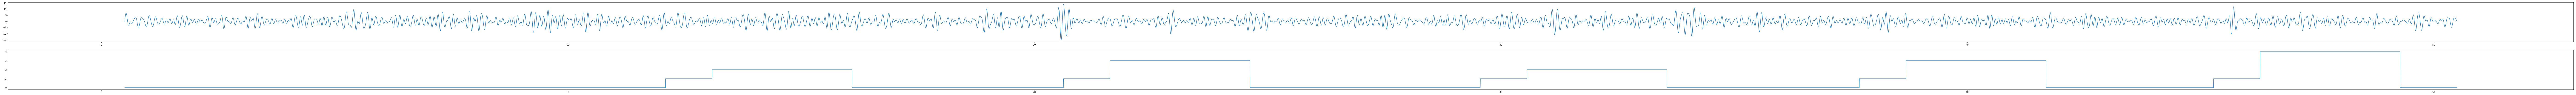

In [25]:
plt.rcParams['figure.figsize'] = [200, 7]
start = int(s1_info['sfreq'] / 2)
stop = int(s1_info['sfreq'] * 1.0)*50 + start
data, t = s1_raw[s1_chs.index('C3')]
filtered = mne.filter.filter_data(data[:, start:stop],s1_info['sfreq'], 7, 13)
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(t[start:stop,], filtered.T * 1.0e6)
plt.subplot(2,1,2)
data2, t2 = s1_raw[s1_chs.index('Stim')]
plt.plot(t2[start:stop,], data2[:,start:stop].T)

Setting up band-pass filter from 7 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 845 samples (1.650 sec)



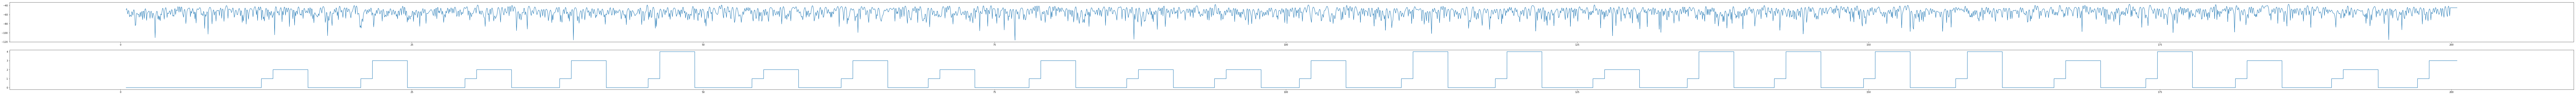

In [122]:
from sklearn.preprocessing import normalize

plt.rcParams['figure.figsize'] =  [200, 7]
start = 250
stop = int(s1_info['sfreq'] * 1.0)*200 + start
data, t = s1_raw[s1_chs.index('C3')]
filtered = mne.filter.filter_data(data[:, start:stop],s1_info['sfreq'], 7, 13)
fig = plt.figure()
WINDOW_SIZE = 20
filtered /= np.std(filtered)
# data2, t2 = s1_raw[s1_chs.index('Stim')]
# plt.subplot(2,1,1)
# plt.plot(t[start:stop],filtered.T)
# plt.subplot(2,1,2)
# plt.plot(t2[start:stop],data2.T[start:stop])
# iterate over power spectrum
powers = []
# steps:
# 1- windowing
# 2- loop over all windows
# 3- Get the average power spectrum
def get_mu_average(signal, srate = 512):

    freq_1_channel, psd_1_channel = biosppy.tools.power_spectrum(signal=signal,
               sampling_rate=s1_info['sfreq'],
               pad=None,
               pow2=False,
               decibel=True)
    return biosppy.signals.tools.band_power(freq_1_channel,psd_1_channel,[7,13])
filtered = filtered.T
ind,vals = biosppy.signals.tools.windower(filtered,50,25,get_mu_average,kernel="hamming")
# print(vals.shape)
# 250
# interpolate values array
ind_extended = np.linspace(start,stop,num=(stop-start))
vals_extended = np.interp(ind_extended,ind,vals[:,0])

# ind_extended = np.interp(np.linspace(start,stop))
# interpolation
# ind_extended = 

# for i in range((stop-start)):
#     freq_1_channel, psd_1_channel = biosppy.tools.power_spectrum(signal=filtered,
#                    sampling_rate=s1_info['sfreq'],
#                    pad=None,
#                    pow2=False,
#                    decibel=True)
#     print(freq_1_channel)
#     powers.append(psd_1_channel)

# psd_1_channel has similar values in each index
# Verify assumption
for i in range(len(psd_1_channel)):
    if not (np.equal(psd_1_channel[i],psd_1_channel[i,0]).all()):
        print("shit")
# plt.plot(freq_1_channel, psd_1_channel[:, 0])
# print(len(powers))
# plt.plot(powers)
plt.subplot(2,1,1)
plt.plot(t[start:stop,],vals_extended)

plt.subplot(2,1,2)
data2, t2 = s1_raw[s1_chs.index('Stim')]
plt.plot(t2[start:stop,], data2[:,start:stop].T)  